<a href="https://colab.research.google.com/github/cameyeam/Projects/blob/main/Prophet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) *100



In [ ]:
# Load the sales data from the sales file
up = pd.read_csv('Sales_Data_Prophet.csv',
                 index_col=[0],
                 parse_dates=[0])
up.head()

,Sales
Date,
2021-01-01,1216852
2021-01-02,1354607
2021-01-03,1187141
2021-01-04,1362440
2021-01-05,1362247


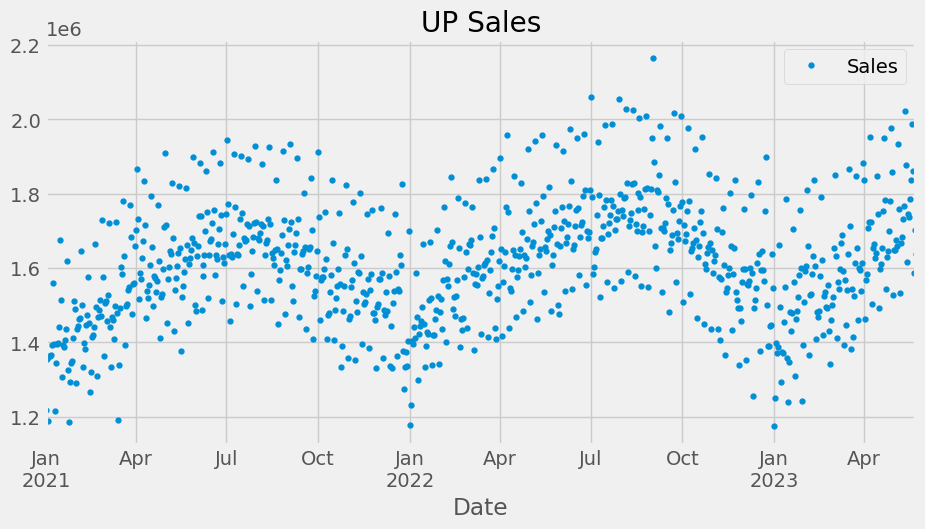

In [ ]:
color_pal = sns.color_palette()
up.plot(style='.',
        figsize=(10,5),
        ms=7,
        color=color_pal[0],
        title='UP Sales')
plt.show()

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])

    # Add a feature indicating sales are 15% higher on Fridays
    df['sales_percentage'] = 1.0  # Initialize the feature column
    df.loc[df['weekday'] == 'Friday', 'sales_percentage'] = 1.15  # Set 15% higher sales on Fridays

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season', 'sales_percentage']]
    if label and label in df.columns:
        y = df[label]
        return X, y
    return X, None


In [ ]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Sales
Date,,,,,,,,,,,
2021-01-01,0,4,1,1,2021,1,1,53,Friday,Winter,1216852
2021-01-02,0,5,1,1,2021,2,2,53,Saturday,Winter,1354607
2021-01-03,0,6,1,1,2021,3,3,53,Sunday,Winter,1187141
2021-01-04,0,0,1,1,2021,4,4,1,Monday,Winter,1362440
2021-01-05,0,1,1,1,2021,5,5,1,Tuesday,Winter,1362247


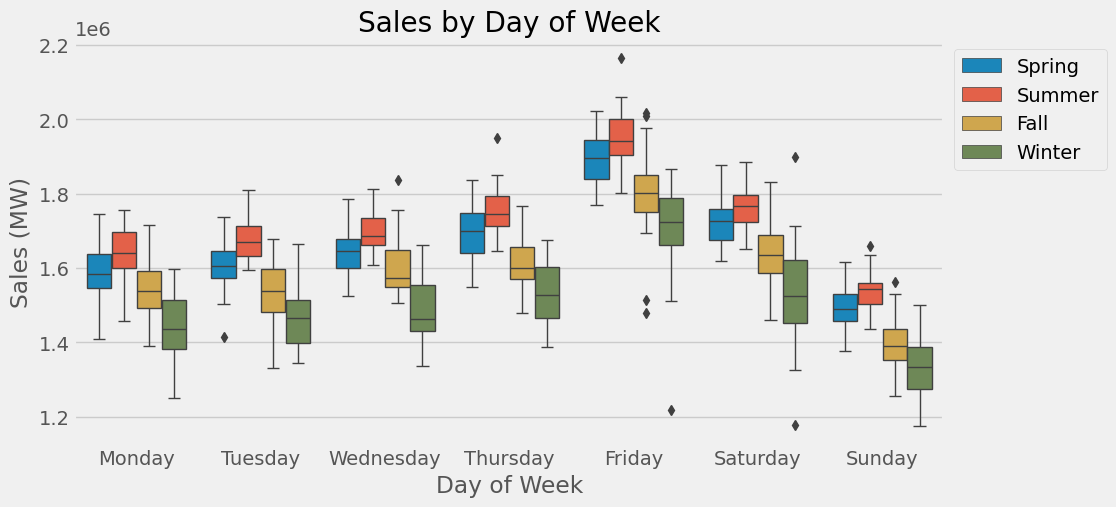

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Sales',  # Replace 'UP_Sales' with the correct column name
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

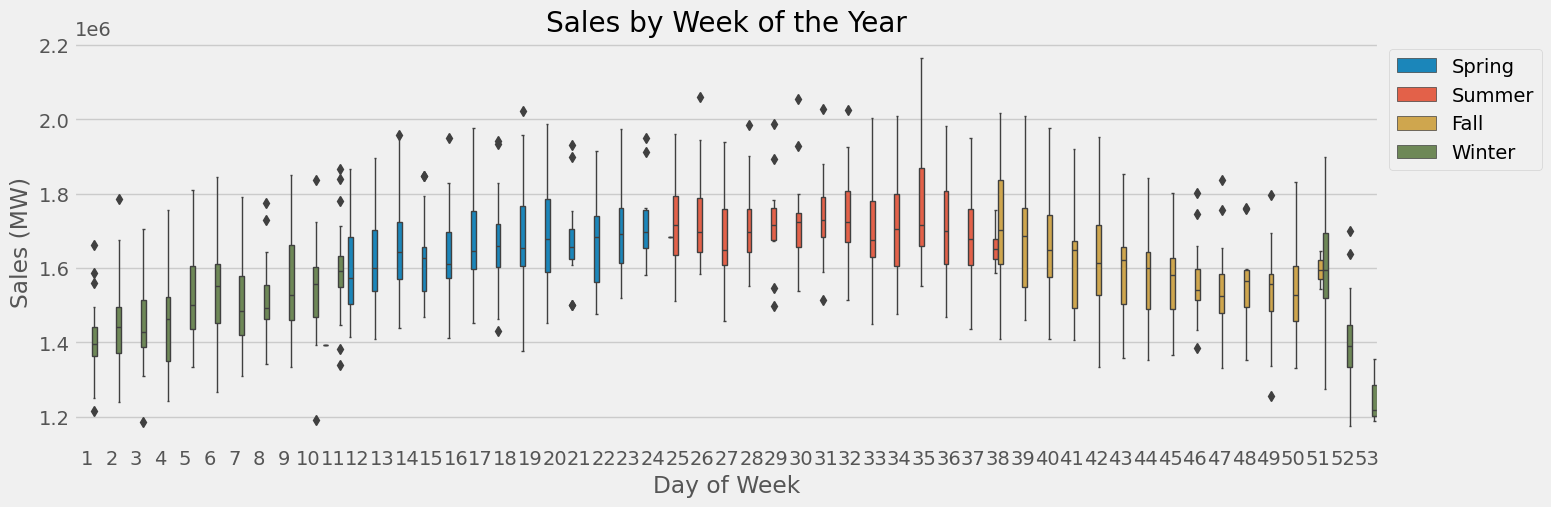

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekofyear',
            y='Sales',  # Replace 'UP_Sales' with the correct column name
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Week of the Year')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

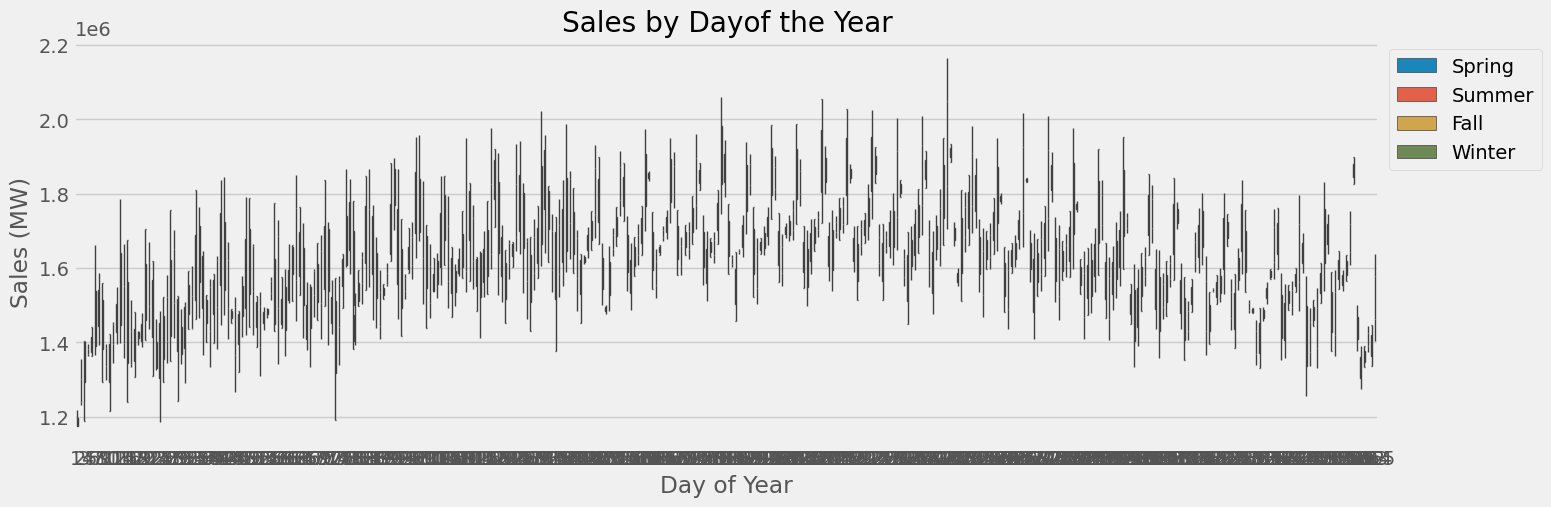

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='dayofyear',
            y='Sales',  # Replace 'UP_Sales' with the correct column name
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Dayof the Year')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Sales (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

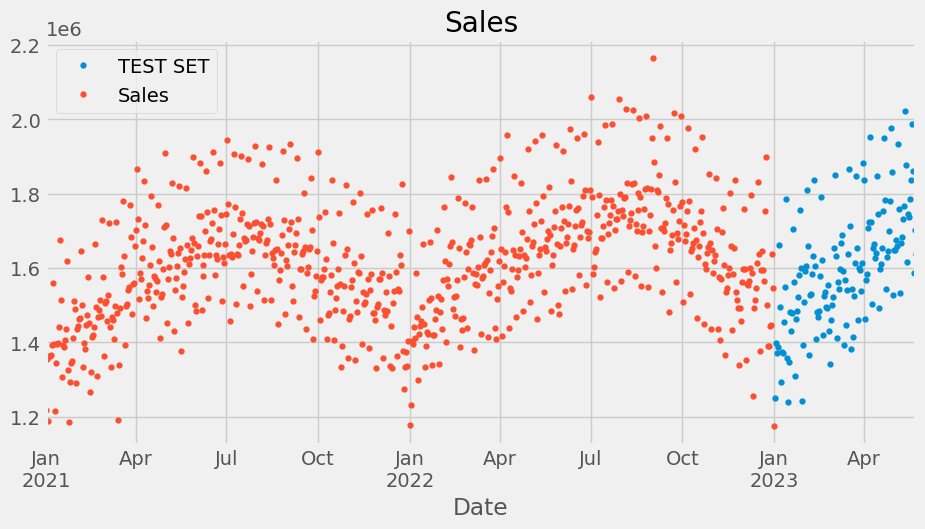

In [ ]:
split_date = '2023-01-01'
up_train = up.loc[up.index <= split_date].copy()
up_test = up.loc[up.index > split_date].copy()

# Plot train and test so you can see where we have split
up_test \
    .rename(columns={'Sales': 'TEST SET'}) \
    .join(up_train.rename(columns={'UP_Sales': 'TRAINING SET'}),
          how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(10, 5), title='Sales', style='.', ms=7)
plt.show()


In [ ]:
# Format data for prophet model using ds and y
up_train_prophet = up_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Sales':'y'})

In [ ]:
%%time
model = Prophet()
model.fit(up_train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vtbumtj/nrq6ki5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vtbumtj/r1izu_pa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58366', 'data', 'file=/tmp/tmp6vtbumtj/nrq6ki5b.json', 'init=/tmp/tmp6vtbumtj/r1izu_pa.json', 'output', 'file=/tmp/tmp6vtbumtj/prophet_modelufbsdhm5/prophet_model-20230531190255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 98.9 ms, sys: 2.54 ms, total: 101 ms
Wall time: 193 ms


In [ ]:
# Predict on test set with model
up_test_prophet = up_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Sales':'y'})

up_test_fcst = model.predict(up_test_prophet)

In [ ]:
up_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,1.681800e+06,1.365611e+06,1.506775e+06,1.681800e+06,1.681800e+06,-248328.576519,-248328.576519,-248328.576519,-61548.845185,-61548.845185,-61548.845185,-186779.731333,-186779.731333,-186779.731333,0.0,0.0,0.0,1.433471e+06
1,2023-01-03,1.681954e+06,1.379751e+06,1.518794e+06,1.681954e+06,1.681954e+06,-232637.401999,-232637.401999,-232637.401999,-43048.967455,-43048.967455,-43048.967455,-189588.434544,-189588.434544,-189588.434544,0.0,0.0,0.0,1.449316e+06
2,2023-01-04,1.682108e+06,1.409443e+06,1.554997e+06,1.682108e+06,1.682108e+06,-199561.636773,-199561.636773,-199561.636773,-7916.104849,-7916.104849,-7916.104849,-191645.531924,-191645.531924,-191645.531924,0.0,0.0,0.0,1.482546e+06
3,2023-01-05,1.682262e+06,1.445463e+06,1.590841e+06,1.682262e+06,1.682262e+06,-164498.105994,-164498.105994,-164498.105994,28427.039279,28427.039279,28427.039279,-192925.145274,-192925.145274,-192925.145274,0.0,0.0,0.0,1.517763e+06
4,2023-01-06,1.682415e+06,1.632987e+06,1.779979e+06,1.682415e+06,1.682415e+06,23566.587070,23566.587070,23566.587070,216983.217858,216983.217858,216983.217858,-193416.630789,-193416.630789,-193416.630789,0.0,0.0,0.0,1.705982e+06


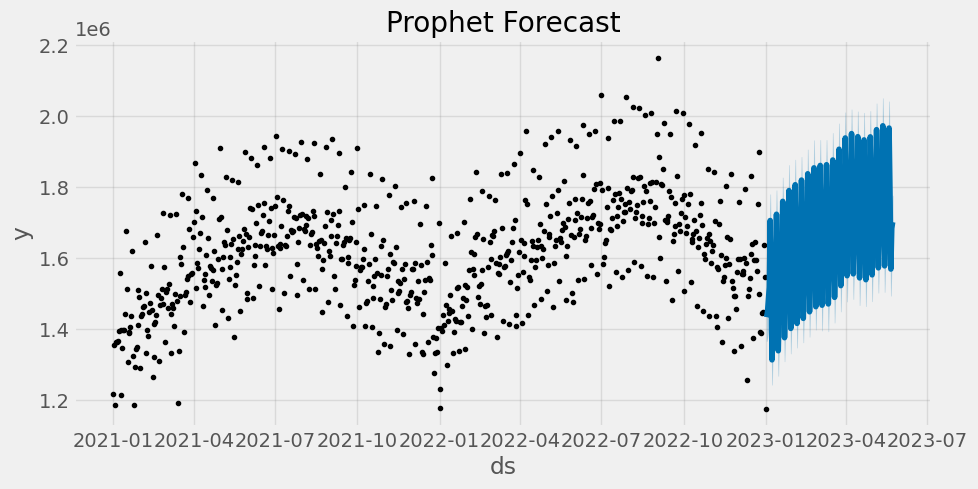

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(up_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

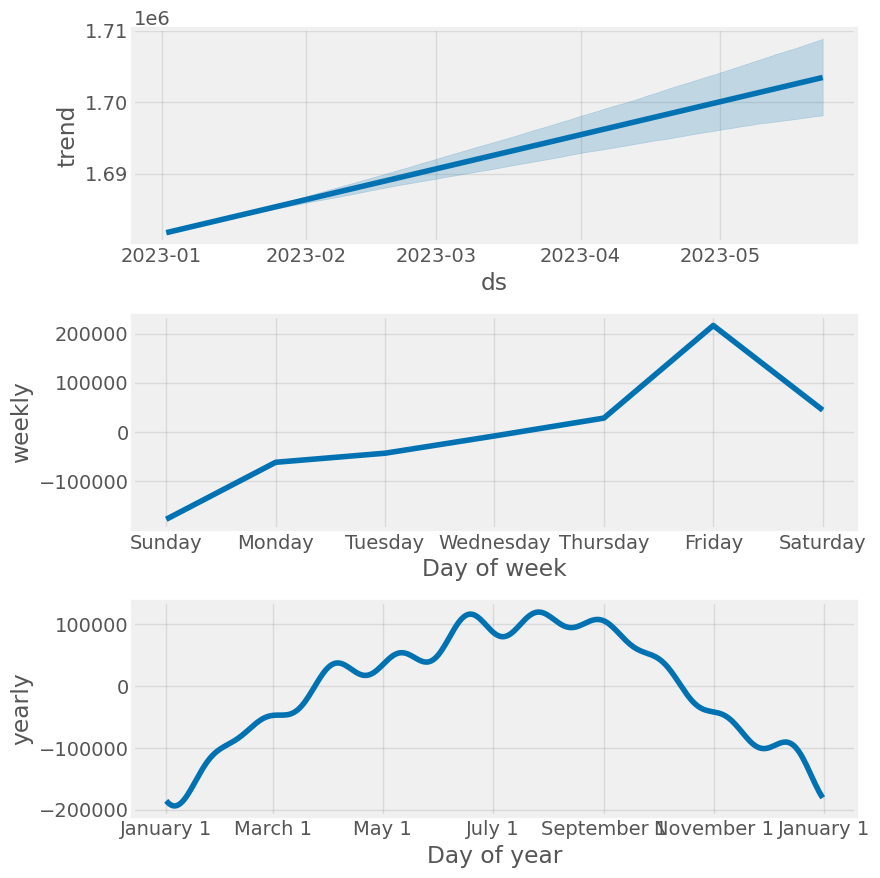

In [ ]:
fig = model.plot_components(up_test_fcst)
plt.show()

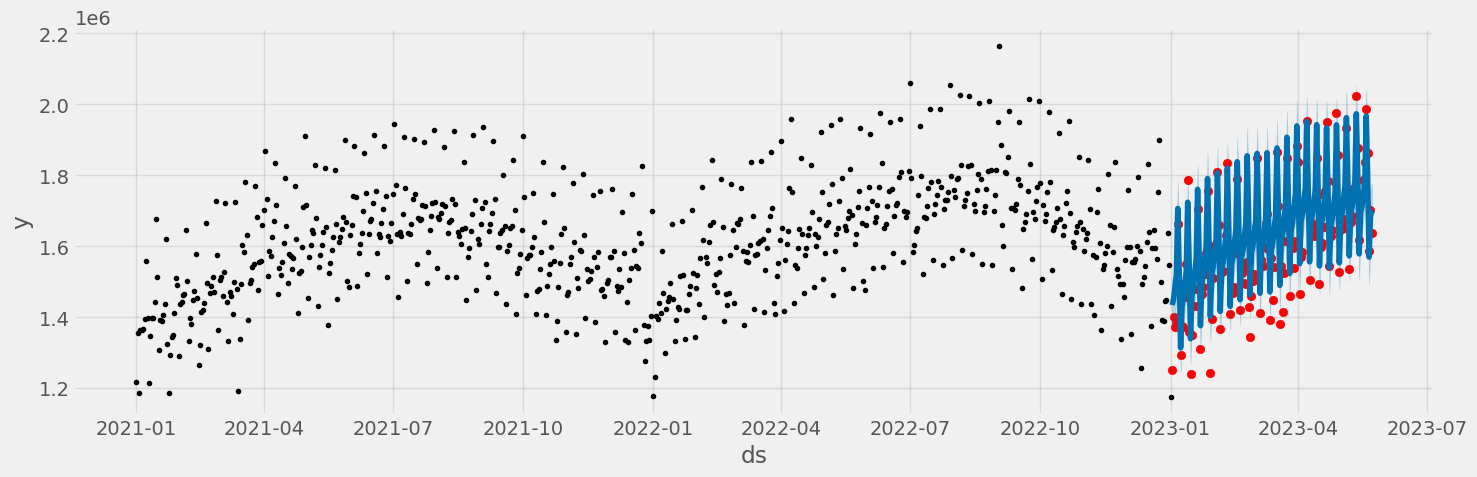

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(up_test.index, up_test['Sales'], color='r')
fig = model.plot(up_test_fcst, ax=ax)

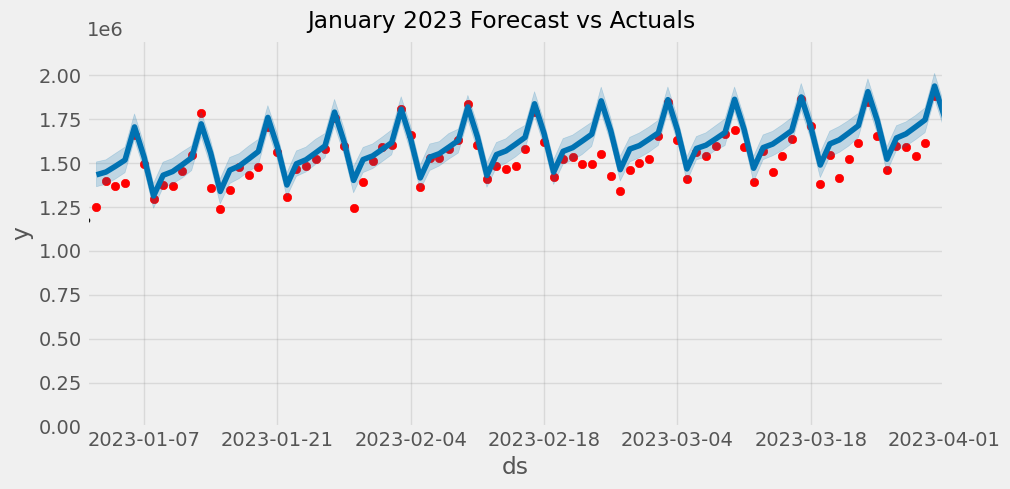

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(up_test.index, up_test['Sales'], color='r')
fig = model.plot(up_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('2023-01-01'),
              upper=pd.Timestamp('2023-04-01'))
ax.set_ylim(0, 2200000)
plot = plt.suptitle('January 2023 Forecast vs Actuals')

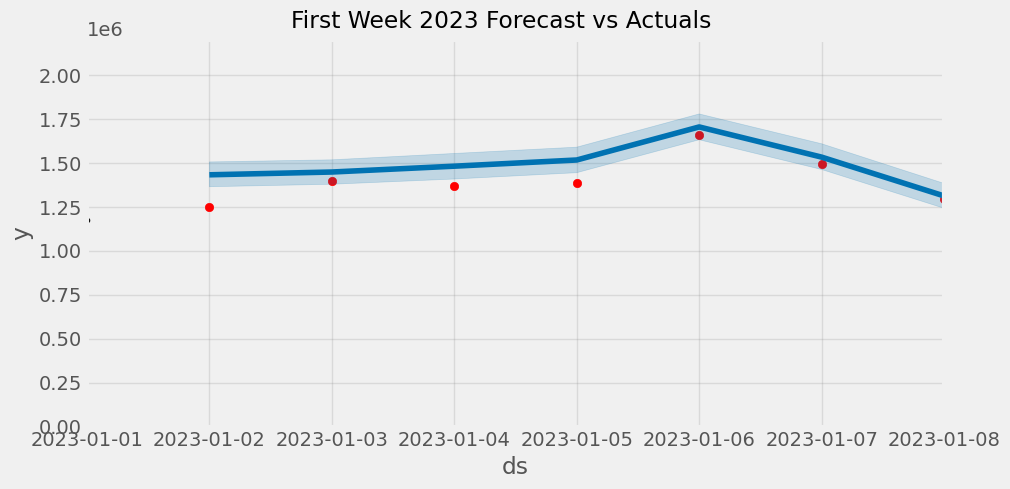

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(up_test.index, up_test['Sales'], color='r')
fig = model.plot(up_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('2023-01-01'),
              upper=pd.Timestamp('2023-01-08'))
ax.set_ylim(0, 2200000)
plot = plt.suptitle('First Week 2023 Forecast vs Actuals')

# Evaluate the model with Error Metrics

In [ ]:
np.sqrt(mean_squared_error(y_true=up_test['Sales'],
                   y_pred=up_test_fcst['yhat']))

81348.18492064034

In [ ]:
mean_absolute_error(y_true=up_test['Sales'],
                   y_pred=up_test_fcst['yhat'])

62291.02594496826

In [ ]:
mean_absolute_percentage_error(y_true=up_test['Sales'],
                   y_pred=up_test_fcst['yhat'])

4.072139826016837

# Adding Holidays

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=up.index.min(),
                        end=up.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(up_train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vtbumtj/k0evcmfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vtbumtj/1_mutdin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54534', 'data', 'file=/tmp/tmp6vtbumtj/k0evcmfw.json', 'init=/tmp/tmp6vtbumtj/1_mutdin.json', 'output', 'file=/tmp/tmp6vtbumtj/prophet_model5_5he2d1/prophet_model-20230531190258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 127 ms, sys: 370 µs, total: 127 ms
Wall time: 250 ms


In [ ]:
# Predict on training set with model
up_test_fcst_with_hols = \
    model_with_holidays.predict(df=up_test_prophet)

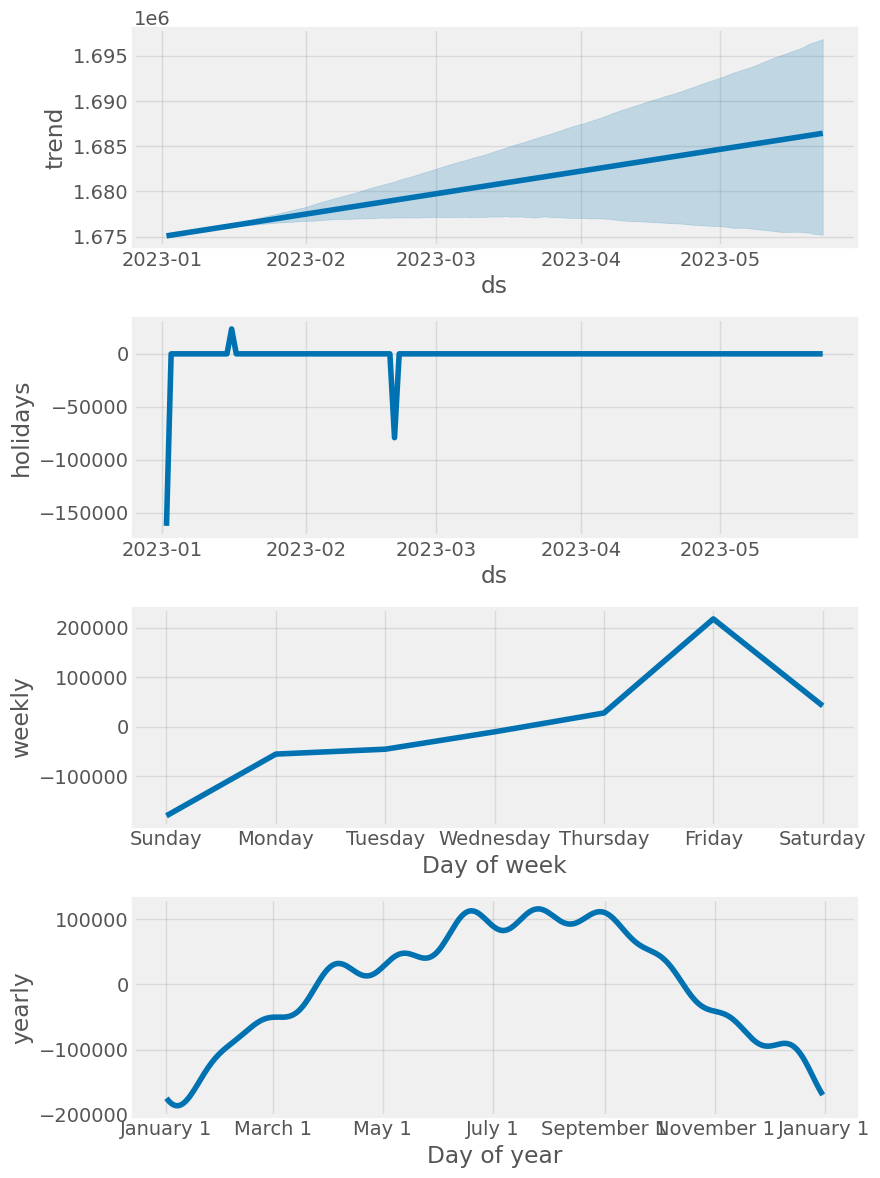

In [ ]:
fig = model_with_holidays.plot_components(
    up_test_fcst_with_hols)
plt.show()

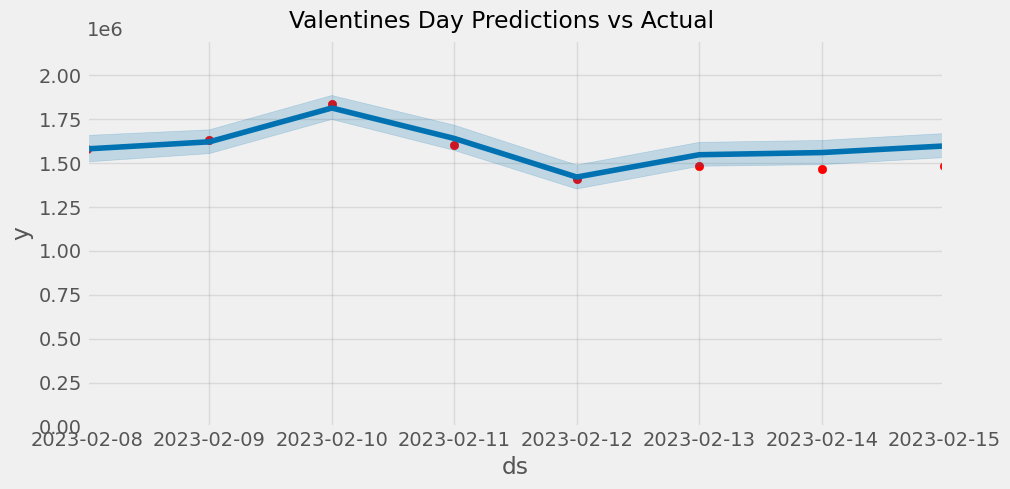

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(up_test.index, up_test['Sales'], color='r')
fig = model.plot(up_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=pd.Timestamp('2023-02-08'),
              upper=pd.Timestamp('2023-02-15'))
ax.set_ylim(0, 2200000)
plot = plt.suptitle('Valentines Day Predictions vs Actual')

In [ ]:
np.sqrt(mean_squared_error(y_true=up_test['Sales'],
                   y_pred=up_test_fcst_with_hols['yhat']))

73296.51857160991

In [ ]:
mean_absolute_error(y_true=up_test['Sales'],
                   y_pred=up_test_fcst_with_hols['yhat'])

54058.322772681764

In [ ]:
mean_absolute_percentage_error(y_true=up_test['Sales'],
                   y_pred=up_test_fcst_with_hols['yhat'])

3.507491814247729

# Predict into the Future

In [ ]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [ ]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2023-01-01 01:00:00,1.324588e+06
1,2023-01-01 02:00:00,1.326994e+06
2,2023-01-01 03:00:00,1.330129e+06
3,2023-01-01 04:00:00,1.333929e+06
4,2023-01-01 05:00:00,1.338327e+06


fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(up_test.index, up_test['Sales'], color='r')
fig = model.plot(up_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('2023-01-01'),
              upper=pd.Timestamp('2023-01-08'))
ax.set_ylim(0, 2200000)
plot = plt.suptitle('First Week 2023 Forecast vs Actuals')